# **Quantitative Economics**
**Problem Set 8**

**Sana Rashidi - 401211522**

# 1 Bellman Equation with Shocks



1. Write a solver class such that it can solve any Bellman problem of the form

$$V(y) = max_{u\in \Gamma(y)} \{r(y,u) +\beta E[V(y\prime)] \} $$
$$s.t. y\prime = h(y, u, \xi)$$

where $\xi$ follows any given distribution.

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from scipy.optimize import fminbound
from numpy import interp
import scipy.stats as stats

In [6]:
def Utility(c, sigma=sigma): #r(y,u)
  if sigma == 1:
    return np.log(c)
  else:
    return (c**(1-sigma))/(1-sigma)

def f(k, alpha=params_dict['alpha']):
  return k**params_dict['alpha']

def h(y,u, shocks):
  return f(y-u)*shocks

def gamma(y):
  return y


def generate_random_samples(distribution_name, N, **kwargs):
    try:
        # Get the distribution from scipy.stats
        distribution = getattr(stats, distribution_name)
        # Generate N random samples
        samples = distribution.rvs(size=N, **kwargs)
        return samples
    except AttributeError:
        raise ValueError(f"Distribution '{distribution_name}' is not found in scipy.stats.")
    except TypeError as e:
        raise ValueError(f"Error generating samples: {e}")


In [7]:
def Bellman_Shock_VFI(w, grid, params_dict, r, h, shock_distribution, grid_max, grid_size, random_seed=1403):
  np.random.seed(random_seed)
  # shock_distribution[0]: name, 1: N, 2: loc, 3:scale
  shocks = generate_random_samples(shock_distribution[0], shock_distribution[1], loc=shock_distribution[2], scale=shock_distribution[3])
  Tw = np.empty(len(w))
  Policy = np.empty(len(w))
  # interpolation for V
  w_func = lambda x: interp(x, grid, w)
  for i, y in enumerate(grid):
    objective =  lambda u: -(r(u) + params_dict['beta'] * np.mean(w_func(h(y, u, shocks))))
    u_star = fminbound(objective, 1e-10, gamma(y))
    Tw[i] = - objective(u_star)
    Policy[i] = u_star

  return Tw, Policy

In [12]:
def VFI_Solve(tolerance, max_iterations, plot=True):
  grid = np.linspace(1e-4, grid_max, grid_size)
  w = 10 * np.log(grid) - 25 # An initial condition -- fairly arbitrary
  Tw = np.empty(len(grid))
  fig, axes = plt.subplots(nrows=1, ncols=2)
  iter = 0
  w_new = np.zeros_like(w)
  i = 0
  error = tolerance + 1
  while error > tolerance and iter < max_iterations:
    w = w_new
    w_new , Policy= Bellman_Shock_VFI(w, grid, params_dict, Utility, h, shock_dist, grid_max, grid_size)
    if plot:
      axes[0].plot(grid, w_new, lw=2, alpha=0.6)
      axes[1].plot(grid, Policy, lw=2, alpha=0.6)
    iter += 1
    i += 1
    error = np.max(np.abs(w-w_new))
  if plot:
    plt.show()
    if error > tolerance:
      print("Failed to converge!")
    else:
      print(f"\nConverged in {i} iterations.")
  else:
    return w_new, Policy


In [13]:
sigma = 1
# grids
grid_max = 4
grid_size = 150
max_iterations = 1000
tolerance = 1e-6
params_dict = {'alpha':0.65, 'beta':0.95}

shock_dist = ('norm', 200, 1, 2)

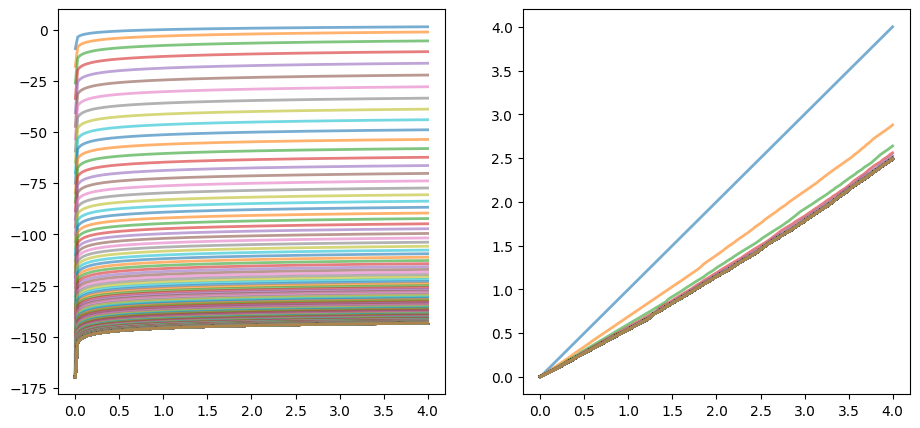


Converged in 312 iterations.


In [14]:
VFI_Solve(tolerance, max_iterations)

2. Write a solver class such that it can solve any Bellman problem of the form

$$V(x, \xi) = \max_{u \in \Gamma (x)} \{r(x,u,\xi)+\beta E[V(x\prime, \xi\prime)|\xi]\}$$
$$s.t. x\prime = g(x,u,\xi)$$

where $\xi$ sollows any given distribution. Use Value Function Iteration method.

In [ ]:
xi = 1
rho = 0.6

In [ ]:
def Bellman_Shock_2(w, grid, params_dict, r,h, shock_distribution, grid_max, grid_size, rho,  xi, random_seed=1403):
  np.random.seed(random_seed)
  # shock_distribution[0]: name, 1: N, 2: loc, 3:scale
  epsilon = generate_random_samples(shock_distribution[0], shock_distribution[1], loc=shock_distribution[2], scale=shock_distribution[3])
  xi_prime = rho*xi*A + np.exp(epsilon)
  Tw = np.empty(len(w))
  Policy = np.empty(len(w))
  # interpolation for V
  w_func = lambda x: interp(x, grid, w)
  for i, y in enumerate(grid):
    objective =  lambda u: -(r(u) + params_dict['beta'] * np.mean(w_func(h(y, u, xi_prime))))
    u_star = fminbound(objective, 1e-10, gamma(y))
    Tw[i] = - objective(u_star)
    Policy[i] = u_star

  return Tw, Policy

In [ ]:
def VFI_Solve_2(tolerance, max_iterations):
  grid = np.linspace(1e-4, grid_max, grid_size)
  w = 10 * np.log(grid) - 25 # An initial condition -- fairly arbitrary
  Tw = np.empty(len(grid))
  iter = 0
  w_new = np.zeros_like(w)
  i = 0
  error = tolerance + 1
  while error > tolerance and iter < max_iterations:
    w = w_new
    w_new , Policy = Bellman_Shock_2(w, grid, params_dict, Utility, h, shock_dist, grid_max, grid_size, rho , xi)
    iter += 1
    i += 1
    error = np.max(np.abs(w-w_new))
  return w_new, Policy, i


# 3 Neoclassical Growth Model with Markov Shocks

Now consider a neoclassical growth model productivity shock with a Markov process:

$$V(k, A) = \max_{c, k^{\prime}} \{U(c)+\beta E[V(k{\prime}, A{\prime})|\xi]\}$$
$$c = Ak^\alpha +(1-\delta)k-k^{\prime}$$
$$\ln A^{\prime} =\rho \ln A + (1-\delta)\ln \bar A +\epsilon$$
$$\ln \epsilon \sim N(0,\omega)$$



1. Use your solvers to solve this problem

In [119]:
def Utility_2(c, sigma=sigma):
  if sigma == 1:
    return np.log(c)
  else:
    return (c**(1-sigma))/(1-sigma)

def f(k, alpha=params_dict['alpha']):
  return k**params_dict['alpha']

def k_prime(k,c,A):
  return A*f(k) + (1-params_dict['delta'])*k-c

def gamma_2(k):
  return f(k) + (1-params_dict['delta'])*k



In [120]:
def Bellman_Shock_VFI_Markov(w, grid, params_dict, utility, k_prime, shock_distribution, grid_max, grid_size, A_rho, A_bar, A, random_seed=1403):
  np.random.seed(random_seed)
  # shock_distribution[0]: name, 1: N, 2: loc, 3:scale
  epsilon = generate_random_samples(shock_distribution[0], shock_distribution[1], loc=shock_distribution[2], scale=shock_distribution[3])
  A_prime = np.exp(A_rho*np.log(A)+(1-A_rho)*np.log(A_bar)+np.exp(epsilon))
  Tw = np.empty(len(w))
  Policy = np.empty(len(w))
  # interpolation for V
  w_func = lambda x: interp(x, grid, w)
  for i, k in enumerate(grid):
    objective =  lambda c: -(utility(c) + params_dict['beta'] * np.mean(w_func(k_prime(k, c, A_prime))))
    c_star = fminbound(objective, 1e-10, gamma_2(k))
    Tw[i] = - objective(c_star)
    Policy[i] = c_star

  return Tw, Policy

In [121]:
def VFI_Solve_Markov(tolerance, max_iterations):
  grid = np.linspace(1e-4, grid_max, grid_size)
  w = 10 * np.log(grid) - 25 # An initial condition -- fairly arbitrary
  Tw = np.empty(len(grid))
  iter = 0
  w_new = np.zeros_like(w)
  i = 0
  error = tolerance + 1
  while error > tolerance and iter < max_iterations:
    w = w_new
    w_new , Policy = Bellman_Shock_VFI_Markov(w, grid, params_dict, Utility_2, k_prime, shock_distribution, grid_max, grid_size, A_rho, A_bar, A)
    iter += 1
    i += 1
    error = np.max(np.abs(w-w_new))
  return w_new, Policy, i


In [122]:
sigma = 1.2
omega = 1
A_rho = 0.3
A_bar = 1
A = 1.2
max_iterations = 1000
tolerance = 1e-2
params_dict = {'alpha':0.65, 'beta':0.95, 'delta':0.08}
# grids
grid_max = 8
grid_size = 150
shock_distribution = ('norm', 150, 0, omega)

In [123]:
Value_function, Policy_function, iteration = VFI_Solve_Markov(tolerance, max_iterations)


Converged in 115 iterations.


Text(0.5, 0, 'Capital Grid')

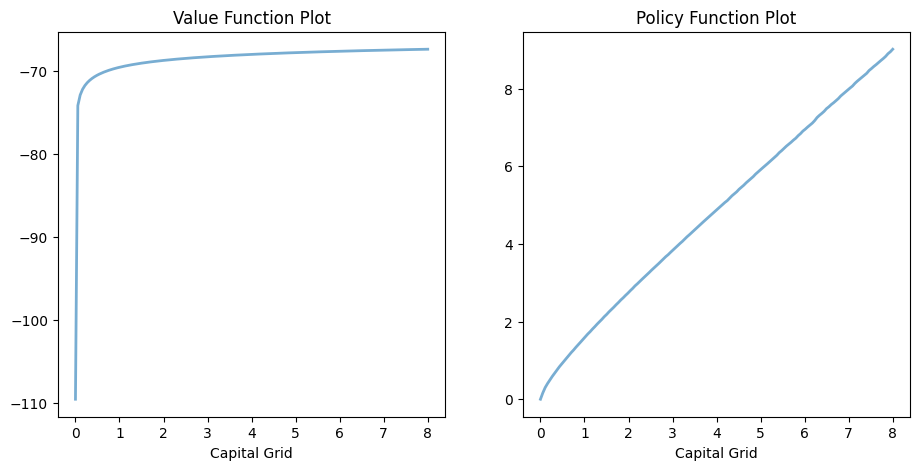

In [124]:
print(f"\nConverged in {iteration} iterations.")
grid = np.linspace(1e-4, grid_max, grid_size)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(grid, Value_function, lw=2, alpha=0.6)
axes[0].set_title('Value Function Plot')
axes[0].set_xlabel('Capital Grid')
#print(w)
axes[1].plot(grid, Policy_function, lw=2, alpha=0.6)
axes[1].set_title('Policy Function Plot')
axes[1].set_xlabel('Capital Grid')

2. How does the mean and the variance of the consumption, output and capital depend on $\bar A$, $\rho$, $\omega$,$\sigma$ $\delta$. Explain intuitivelt why we observe these results.

$\bar A$

In [125]:
A_bar = 1.5
Value_function_1, Policy_function_1, iteration = VFI_Solve_Markov(tolerance, max_iterations)
A_bar = 2
Value_function_2, Policy_function_2, iteration = VFI_Solve_Markov(tolerance, max_iterations)
A_bar = 3
Value_function_3, Policy_function_3, iteration = VFI_Solve_Markov(tolerance, max_iterations)

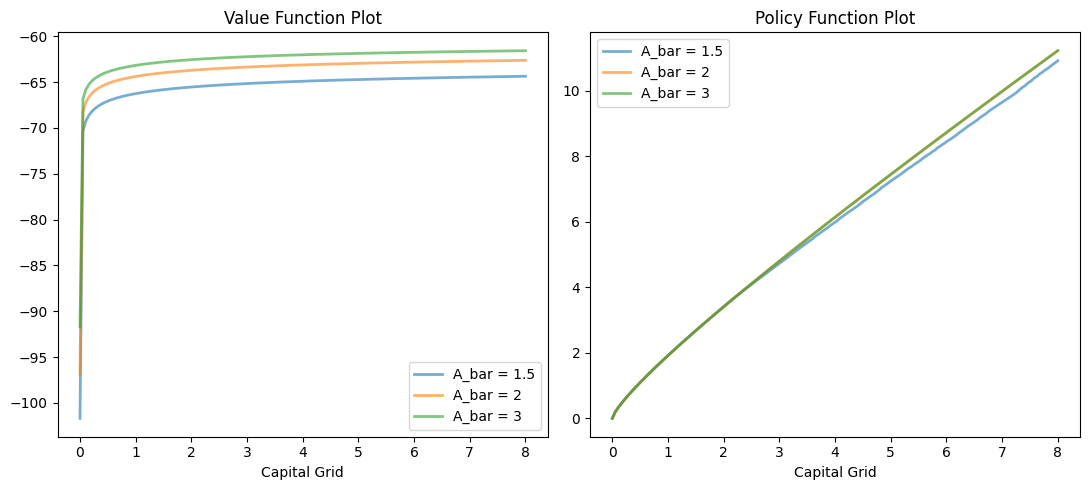

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(grid, Value_function_1, lw=2, alpha=0.6, label='A_bar = 1.5')
axes[0].plot(grid, Value_function_2, lw=2, alpha=0.6, label='A_bar = 2')
axes[0].plot(grid, Value_function_3, lw=2, alpha=0.6, label='A_bar = 3')
axes[0].set_title('Value Function Plot')
axes[0].set_xlabel('Capital Grid')
axes[0].legend()
#print(w)
axes[1].plot(grid, Policy_function_1, lw=2, alpha=0.6, label='A_bar = 1.5')
axes[1].plot(grid, Policy_function_2, lw=2, alpha=0.6, label='A_bar = 2')
axes[1].plot(grid, Policy_function_3, lw=2, alpha=0.6, label='A_bar = 3')
axes[1].set_title('Policy Function Plot')
axes[1].set_xlabel('Capital Grid')
axes[1].legend()

plt.tight_layout()


plt.show()

In [65]:
print('average of consumption when A_bar = 1.5:  ',np.mean(Policy_function_1))
print('average of consumption when A_bar = 2:  ',np.mean(Policy_function_2))
print('average of consumption when A_bar = 3:  ',np.mean(Policy_function_3))

print('variance of consumption when A_bar = 1.5:  ',np.var(Policy_function_1))
print('variance of consumption when A_bar = 2:  ',np.var(Policy_function_2))
print('variance of consumption when A_bar = 3:  ',np.var(Policy_function_3))

average of consumption when A_bar = 1.5:   5.961171405308684
average of consumption when A_bar = 2:   6.018867434362156
average of consumption when A_bar = 3:   6.018867434362156
variance of consumption when A_bar = 1.5:   9.644213736655786
variance of consumption when A_bar = 2:   9.896951024249226
variance of consumption when A_bar = 3:   9.896951024249226


$\rho$

In [67]:
A_bar = 1
A_rho = 0.5
Value_function_1, Policy_function_1, iteration = VFI_Solve_Markov(tolerance, max_iterations)
A_rho = 0.7
Value_function_2, Policy_function_2, iteration = VFI_Solve_Markov(tolerance, max_iterations)
A_rho = 0.9
Value_function_3, Policy_function_3, iteration = VFI_Solve_Markov(tolerance, max_iterations)

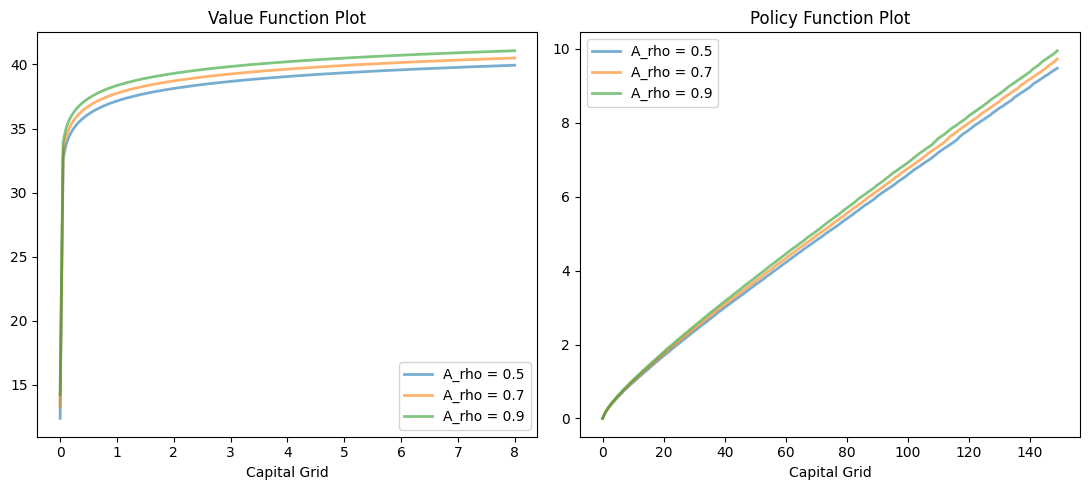

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(grid, Value_function_1, lw=2, alpha=0.6, label='A_rho = 0.5')
axes[0].plot(grid, Value_function_2, lw=2, alpha=0.6, label='A_rho = 0.7')
axes[0].plot(grid, Value_function_3, lw=2, alpha=0.6, label='A_rho = 0.9')
axes[0].set_title('Value Function Plot')
axes[0].set_xlabel('Capital Grid')
axes[0].legend()
#print(w)
axes[1].plot(Policy_function_1, lw=2, alpha=0.6, label='A_rho = 0.5')
axes[1].plot(Policy_function_2, lw=2, alpha=0.6, label='A_rho = 0.7')
axes[1].plot(Policy_function_3, lw=2, alpha=0.6, label='A_rho = 0.9')
axes[1].set_title('Policy Function Plot')
axes[1].set_xlabel('Capital Grid')
axes[1].legend()

plt.tight_layout()


plt.show()

In [69]:
print('average of consumption when A_rho = 0.5:  ',np.mean(Policy_function_1))
print('average of consumption when A_rho = 0.7:  ',np.mean(Policy_function_2))
print('average of consumption when A_rho = 0.9:  ',np.mean(Policy_function_3))

print('variance of consumption when A_rho = 0.5:  ',np.var(Policy_function_1))
print('variance of consumption when A_rho = 0.7:  ',np.var(Policy_function_2))
print('variance of consumption when A_rho = 0.9:  ',np.var(Policy_function_3))

average of consumption when A_rho = 0.5:   5.025508665594443
average of consumption when A_rho = 0.7:   5.152589456203602
average of consumption when A_rho = 0.9:   5.283440719930481
variance of consumption when A_rho = 0.5:   7.041503945603596
variance of consumption when A_rho = 0.7:   7.35855540009989
variance of consumption when A_rho = 0.9:   7.693657062979046


$\sigma$

In [81]:
A_bar = 1
A_rho = 0.3
omega = 1
sigma = 1.5
def Utility_2(c, sigma=sigma):
  if sigma == 1:
    return np.log(c)
  else:
    return (c**(1-sigma))/(1-sigma)

Value_function_1, Policy_function_1, iteration = VFI_Solve_Markov(tolerance, max_iterations)
sigma = 2
def Utility_2(c, sigma=sigma):
  if sigma == 1:
    return np.log(c)
  else:
    return (c**(1-sigma))/(1-sigma)

Value_function_2, Policy_function_2, iteration = VFI_Solve_Markov(tolerance, max_iterations)
sigma = 2.5
def Utility_2(c, sigma=sigma):
  if sigma == 1:
    return np.log(c)
  else:
    return (c**(1-sigma))/(1-sigma)

Value_function_3, Policy_function_3, iteration = VFI_Solve_Markov(tolerance, max_iterations)

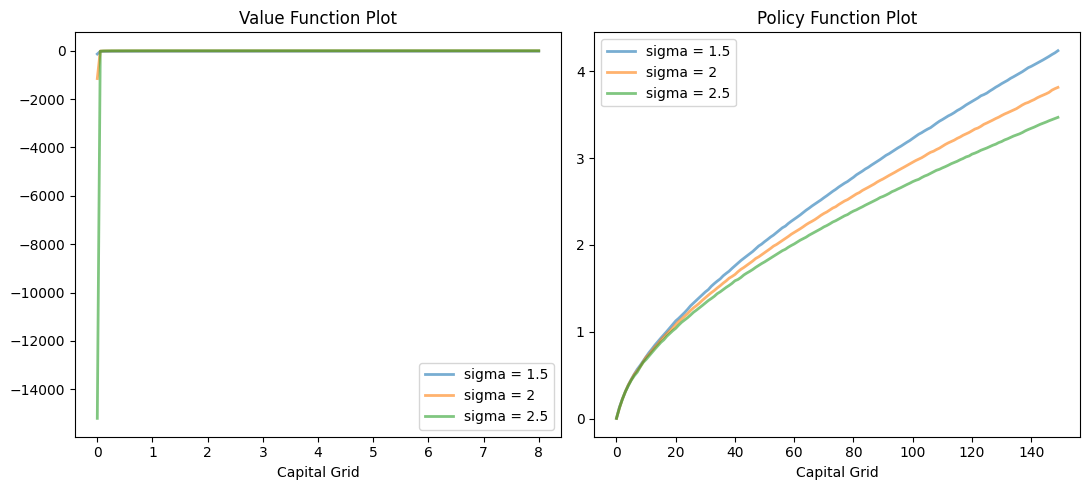

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(grid, Value_function_1, lw=2, alpha=0.6, label='sigma = 1.5')
axes[0].plot(grid, Value_function_2, lw=2, alpha=0.6, label='sigma = 2')
axes[0].plot(grid, Value_function_3, lw=2, alpha=0.6, label='sigma = 2.5')
axes[0].set_title('Value Function Plot')
axes[0].set_xlabel('Capital Grid')
axes[0].legend()
#print(w)
axes[1].plot(Policy_function_1, lw=2, alpha=0.6, label='sigma = 1.5')
axes[1].plot(Policy_function_2, lw=2, alpha=0.6, label='sigma = 2')
axes[1].plot(Policy_function_3, lw=2, alpha=0.6, label='sigma = 2.5')
axes[1].set_title('Policy Function Plot')
axes[1].set_xlabel('Capital Grid')
axes[1].legend()

plt.tight_layout()


plt.show()

In [83]:
print('average of consumption when sigma = 1.1:  ',np.mean(Policy_function_1))
print('average of consumption when sigma = 1.3:  ',np.mean(Policy_function_2))
print('average of consumption when sigma = 1.5:  ',np.mean(Policy_function_3))

print('variance of consumption when sigma = 1.1:  ',np.var(Policy_function_1))
print('variance of consumption when sigma = 1.3:  ',np.var(Policy_function_2))
print('variance of consumption when sigma = 1.5:  ',np.var(Policy_function_3))

average of consumption when sigma = 1.1:   2.529805195091921
average of consumption when sigma = 1.3:   2.329202157659044
average of consumption when sigma = 1.5:   2.163925234570928
variance of consumption when sigma = 1.1:   1.2385725477600815
variance of consumption when sigma = 1.3:   0.973930684116635
variance of consumption when sigma = 1.5:   0.7872473166155339


$\delta$

In [76]:
A_bar = 1
A_rho = 0.3
omega = 1
sigma = 1.2
params_dict['delta']=0.3
Value_function_1, Policy_function_1, iteration = VFI_Solve_Markov(tolerance, max_iterations)
params_dict['delta']=0.6
Value_function_2, Policy_function_2, iteration = VFI_Solve_Markov(tolerance, max_iterations)
params_dict['delta']=0.9
Value_function_3, Policy_function_3, iteration = VFI_Solve_Markov(tolerance, max_iterations)

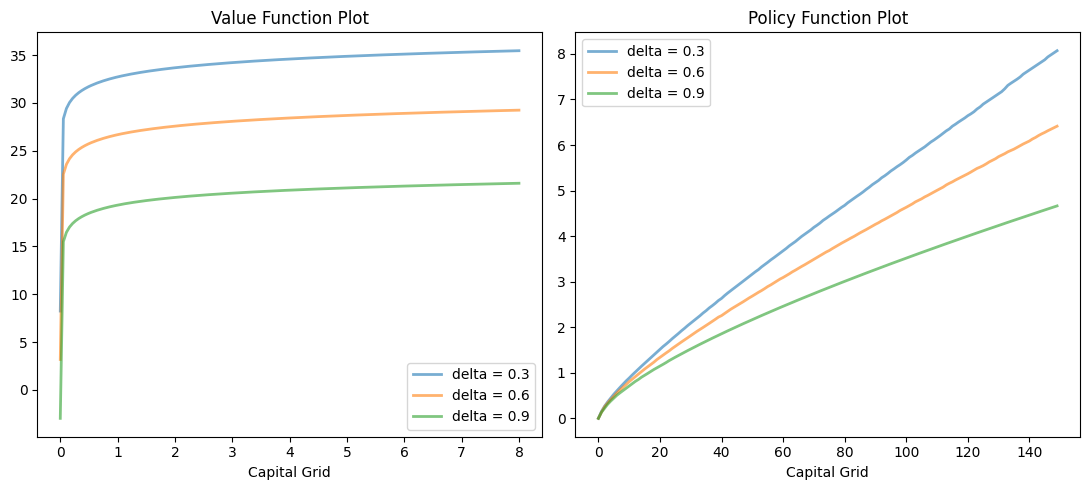

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(grid, Value_function_1, lw=2, alpha=0.6, label='delta = 0.3')
axes[0].plot(grid, Value_function_2, lw=2, alpha=0.6, label='delta = 0.6')
axes[0].plot(grid, Value_function_3, lw=2, alpha=0.6, label='delta = 0.9')
axes[0].set_title('Value Function Plot')
axes[0].set_xlabel('Capital Grid')
axes[0].legend()
#print(w)
axes[1].plot(Policy_function_1, lw=2, alpha=0.6, label='delta = 0.3')
axes[1].plot(Policy_function_2, lw=2, alpha=0.6, label='delta = 0.6')
axes[1].plot(Policy_function_3, lw=2, alpha=0.6, label='delta = 0.9')
axes[1].set_title('Policy Function Plot')
axes[1].set_xlabel('Capital Grid')
axes[1].legend()

plt.tight_layout()


plt.show()

In [78]:
print('average of consumption when delta = 0.3:  ',np.mean(Policy_function_1))
print('average of consumption when delta = 0.6:  ',np.mean(Policy_function_2))
print('average of consumption when delta = 0.9:  ',np.mean(Policy_function_3))

print('variance of consumption when delta = 0.3:  ',np.var(Policy_function_1))
print('variance of consumption when delta = 0.6:  ',np.var(Policy_function_2))
print('variance of consumption when delta = 0.9:  ',np.var(Policy_function_3))

average of consumption when delta = 0.3:   4.334270462864243
average of consumption when delta = 0.6:   3.5645703483428237
average of consumption when delta = 0.9:   2.7377842310126494
variance of consumption when delta = 0.3:   5.00607257847723
variance of consumption when delta = 0.6:   3.0873895778058964
variance of consumption when delta = 0.9:   1.5525489371126215


Higher productivity ((A)) allows for more efficient production of goods and services from a given amount of capital. When A increases Since more output can be produced with the same capital stock, consumption ((c)) increases. Agents can afford to consume more without compromising future production. Higher productivity encourages investment, leading to an increase in the capital stock ((k)). This, in turn, contributes to higher future production.Total production (output) rises due to increased efficiency.

The utility function represents an agent’s satisfaction from consuming goods.The shape of the utility function determines how much an agent values consumption. If the utility function is concave (diminishing marginal utility), agents will save more and consume less. If it is convex (increasing marginal utility), agents will consume more.The utility function indirectly affects capital accumulation. Higher utility from consumption encourages saving, leading to more investment and capital accumulation.The impact on production depends on how consumption and investment decisions interact. If the intertemporal substituition increases, people want more consumption smoothing.

 Higher depreciation means more capital is needed to maintain the same level of production. Thus, consumption decreases.A higher delta leads to faster capital decay. Agents need to invest more to offset depreciation, resulting in a lower steady-state capital stock. Increased depreciation reduces the effective capital stock, leading to lower production.

 The shock term introduces uncertainty into the model. Higher uncertainty may lead agents to save more as a precaution against bad shocks. Thus, consumption might decrease.Uncertainty affects investment decisions. If agents are risk-averse, they may invest less due to the risk associated with shocks.Variability in productivity shocks impacts overall production. In periods of high shocks, production may be lower.When productivity shocks are more volatile (higher (\omega^2)), agents face greater uncertainty about future income.
Risk-averse agents tend to save more as a precaution against bad shocks. This leads to lower current consumption.
Overall, higher uncertainty reduces immediate consumption levels.Uncertainty affects investment decisions.
Risk-averse agents may invest less due to the risk associated with productivity shocks.
Lower investment means slower capital accumulation.

# 4 Neoclassical Growth Model with Finite States Shocks


Consider the Stochastic Neoclassical Growth Model:

$$V(k, A)=\max_{k^{\prime}} \{U(Ak^{\alpha}+(1-\delta)k-k^{\prime})+\beta E[V(k^{\prime}, A^{\prime})\}$$

where $A \in \{A_{H} , A_{L}\}$ is a Markov process with transition matrix $P$.



1. Use the previous solvers to solve this Stochastic neoclassical growth model. Find $g(k,A_{H}), g(k, A_{L})$.

2. Simulate the model and …nd the stationary distribution of capital. To do so, start with
and arbitrary value for capital and simulate the model for N + 100 periods. Drop the first
100 periods and consider the N periods thereafter. Plot the histogram of capital for these
values. Try N = 1000, 10000, 100000

I used codes from quantecon for this questions

In [139]:
from scipy.optimize import minimize_scalar
from scipy.stats import gaussian_kde

In [142]:
# states
A_H, A_L = 1.5, 0.5
# grid
grid_max = 10
grid_size = 1000
grid = np.linspace(1e-4, grid_max, grid_size)
# parameters
params = {'alpha':0.66, 'delta':0.4, 'sigma':1.2, 'beta': 0.95}

tolerance = 1e-3
max_iterations = 1000

P = np.array([(0.4, 0.6),(0.6, 0.4)])

In [135]:
# functions
def U(c):
  if params['sigma'] == 1:
    return np.log(c)
  else:
    return (c**(1-params['sigma']))/(1-params['sigma'])
def Production(k, A):
  return A*k**params['alpha']

def Consumption(k , k_prime, A):
  return Production(k, A) + (1-params['delta'])*k-k_prime

def Gamma(k,A):
  return Production(k, A) + (1-params['delta'])*k - 1e-4

def state_action_value(k, k_prime, A, V_H, V_L):
    """
    Right hand side of the Bellman equation
    """
    # interpolation ()
    V_H_interp = np.interp(k_prime, grid, V_H)
    V_L_interp = np.interp(k_prime, grid, V_L)

    # transition matrix
    # (HH , HL),(LH , LL)
    P = np.array([(0.4, 0.6),(0.6, 0.4)])
    # based on state of A, we can have two different value functions and have to get the expected with the transition matrix
    if A == A_L:
      E_V = P[1,1]*V_L_interp + P[1,0]*V_H_interp
    else:
      E_V = P[0,0]*V_H_interp + P[0,1]*V_L_interp

    c = Consumption(k, k_prime, A)
    return U(c) + params['beta']*E_V


In [136]:
def Bellman_Operator(V_L, V_H, A_L, A_H):
  def Max_V_H(k):
    result = minimize_scalar(lambda k_prime_H: -state_action_value(k, k_prime_H, A_H, V_H, V_L), bounds=(1e-6,Gamma(k, A_H)), method='bounded')
    k_star_H, v_star_H = result.x, -result.fun
    return k_star_H, v_star_H
  vectorized_operator_1 = np.vectorize(Max_V_H)
  Policy_H, V_new_H = vectorized_operator_1(grid)

  def Max_V_L(k):
    result = minimize_scalar(lambda k_prime_L: -state_action_value(k, k_prime_L, A_L, V_H, V_L), bounds=(1e-6,Gamma(k, A_L)), method='bounded')
    k_star_L, v_star_L = result.x, -result.fun
    return k_star_L, v_star_L
  vectorized_operator_2 = np.vectorize(Max_V_L)
  Policy_L, V_new_L = vectorized_operator_2(grid)

  return Policy_H, V_new_H, Policy_L, V_new_L


In [137]:
def solve_model(A_H, A_L, grid, tolerance, max_iterations):
    V_H = np.log(grid)
    V_L = 0.5*np.log(grid)
    iter = 0
    error = tolerance + 1
    while error > tolerance and iter < max_iterations:
      Policy_new_H, V_new_H, Policy_new_L, V_new_L = Bellman_Operator(V_L, V_H, A_L, A_H)
      error = np.max([np.max(np.abs(V_H - V_new_H)), np.max(np.abs(V_L - V_new_L))])
      V_H, V_L = V_new_H, V_new_L
      iter += 1
    if error > tolerance :
      print("Failed to converge!")
    else:
      print(f"\nConverged in {iter} iterations")
    return Policy_new_H, V_new_H, Policy_new_L, V_new_L


In [138]:

Policy_new_H, V_new_H, Policy_new_L, V_new_L = solve_model(A_H, A_L, grid, tolerance, max_iterations)


Converged in 169 iterations


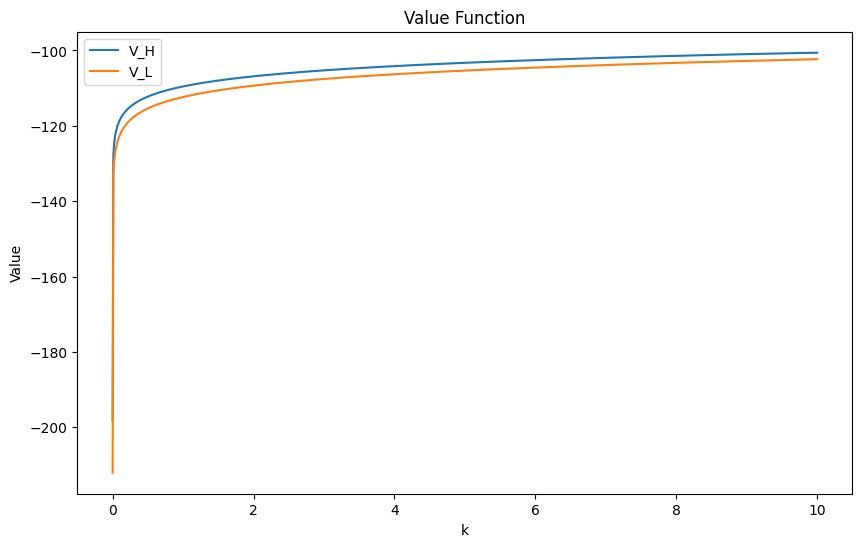

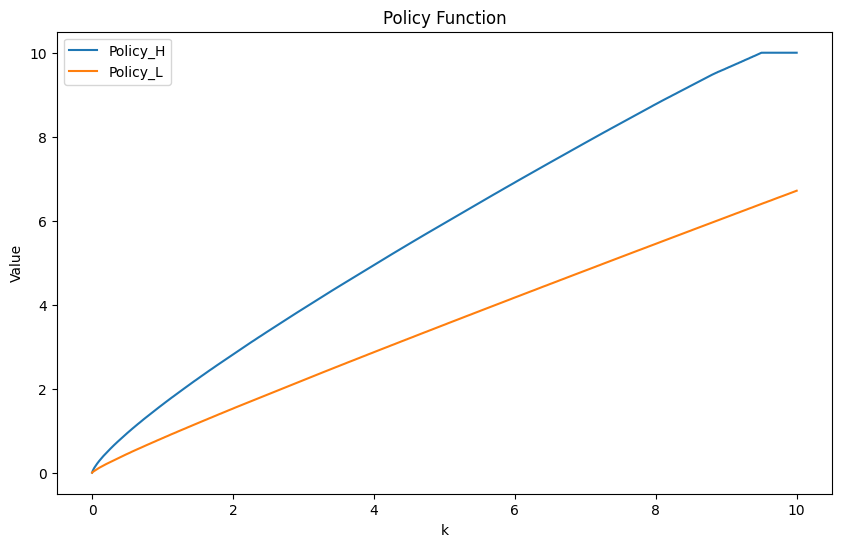

In [140]:

plt.figure(figsize=(10, 6))
plt.plot(grid, V_new_H, label='V_H')
plt.plot(grid, V_new_L, label='V_L')
plt.title('Value Function')
plt.xlabel('k')
plt.ylabel('Value')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(grid, Policy_new_H, label='Policy_H')
plt.plot(grid, Policy_new_L, label='Policy_L')
plt.title('Policy Function')
plt.xlabel('k')
plt.ylabel('Value')
plt.legend()
plt.show()

 Simulate the model and find the stationary distribution of capital.

In [158]:
def choose_next_state(P, current_state):
    """
    Randomly select the next state based on the current state and transition probabilities.
    """
    random_val = np.random.random()
    cum_prob = 0
    future_state = None
    for idx, probability in enumerate(P[current_state]):
        cum_prob += probability
        if random_val <= cum_prob:
            future_state = idx
            break
    return future_state

# Initial state setup
initial_state = 1

# Number of transitions to simulate
num_transitions = 100000

# Array to store the sequence of states
states_sequence = np.empty(num_transitions)
for i in range(num_transitions):
    states_sequence[i] = choose_next_state(P, initial_state)

# Interpolation functions for high and low state transitions
interpol_high = lambda val: np.interp(val, grid, Policy_new_H)
interpol_low = lambda val: np.interp(val, grid, Policy_new_L)

# Array to store capital values over time
capital_sequence = np.empty(num_transitions + 1)
capital_sequence[0] = 5

# Simulate the evolution of capital based on state transitions
for t in range(num_transitions):
    if states_sequence[t] == 0:
        capital_sequence[t + 1] = interpol_high(capital_sequence[t])
    elif states_sequence[t] == 1:
        capital_sequence[t + 1] = interpol_low(capital_sequence[t])

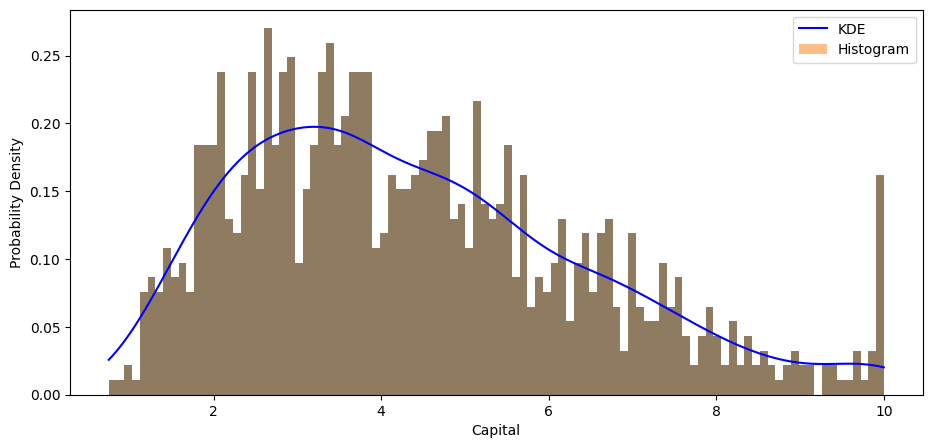

In [159]:
T = 1000
capital_sample = capital_sequence[100:100+T]

# Create the histogram
plt.hist(capital_sample, bins=100, density=True)
kde = gaussian_kde(capital_sample)

# Generate points for plotting the KDE curve
x_vals = np.linspace(capital_sample.min(), capital_sample.max(), 1000)
kde_vals = kde.evaluate(x_vals)

# Plot the KDE curve
plt.plot(x_vals, kde_vals, color='blue', label='KDE')

# Plot the histogram with adjusted bins
plt.hist(capital_sample, bins=100, density=True, alpha=0.5,label='Histogram')

# Add labels and title
plt.xlabel('Capital')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()
# Display the plot
plt.show()

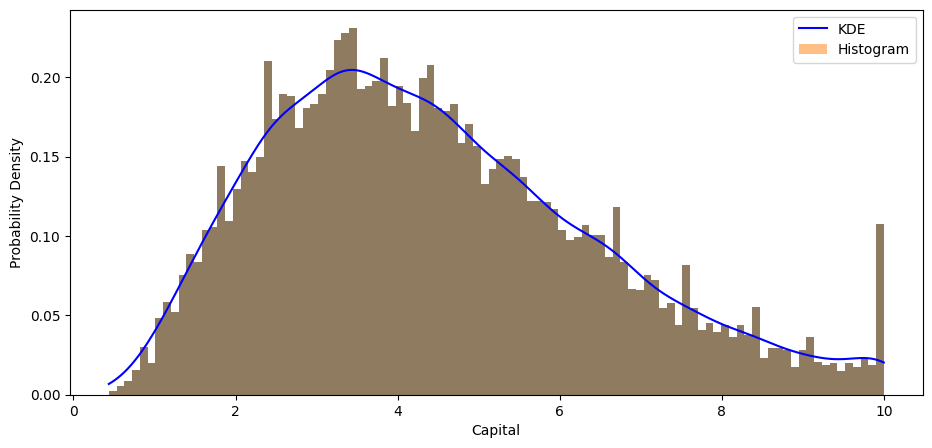

In [160]:
T = 10000
capital_sample = capital_sequence[100:100+T]

# Create the histogram
plt.hist(capital_sample, bins=100, density=True)
kde = gaussian_kde(capital_sample)

# Generate points for plotting the KDE curve
x_vals = np.linspace(capital_sample.min(), capital_sample.max(), 1000)
kde_vals = kde.evaluate(x_vals)

# Plot the KDE curve
plt.plot(x_vals, kde_vals, color='blue', label='KDE')

# Plot the histogram with adjusted bins
plt.hist(capital_sample, bins=100, density=True, alpha=0.5,label='Histogram')

# Add labels and title
plt.xlabel('Capital')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()
# Display the plot
plt.show()

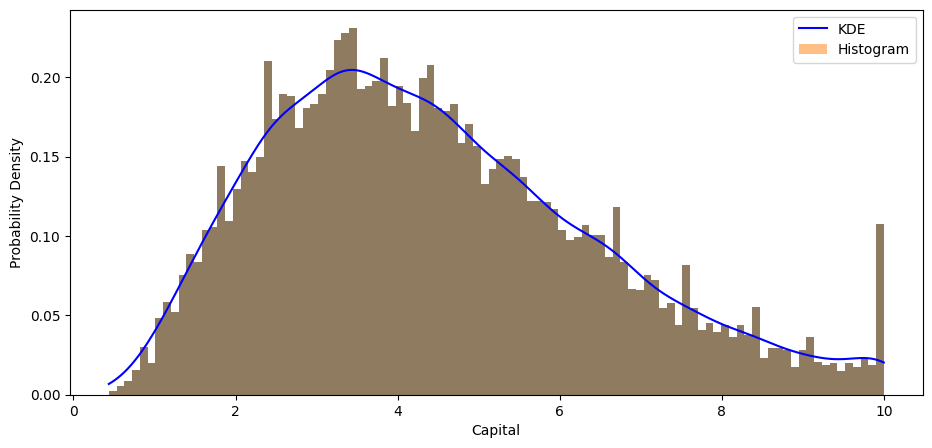

In [161]:
T = 10000
capital_sample = capital_sequence[100:100+T]

# Create the histogram
plt.hist(capital_sample, bins=100, density=True)
kde = gaussian_kde(capital_sample)

# Generate points for plotting the KDE curve
x_vals = np.linspace(capital_sample.min(), capital_sample.max(), 1000)
kde_vals = kde.evaluate(x_vals)

# Plot the KDE curve
plt.plot(x_vals, kde_vals, color='blue', label='KDE')

# Plot the histogram with adjusted bins
plt.hist(capital_sample, bins=100, density=True, alpha=0.5,label='Histogram')

# Add labels and title
plt.xlabel('Capital')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()
# Display the plot
plt.show()

# 5 Discrete Dynamic Programming

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
def Discrete_DP(r, sigma, omega, beta, s0, s1, N, epsilon):
    a_max = 5.0
    a_min = 0.0

    def U(a, a_prime, s):
        if (1 + r)*a + omega*s - a_prime > 0:
            return ((1 + r)*a + omega*s - a_prime)**(1 - sigma) / (1 - sigma)
        else:
            return 0.0

    def Gamma(a, s):
        return min((1 + r)*a + omega*s, a_max)

    a_grid = np.linspace(a_min, a_max, N)
    V1 = [a_grid]
    V2 = [a_grid]
    Vj1 = np.zeros(N)
    Vj2 = np.zeros(N)
    R1 = np.zeros((N, N))
    R2 = np.zeros((N, N))

    for i in range(N):
        R1[i, :] = [U(a_grid[i], a, s0) for a in a_grid]
        R2[i, :] = [U(a_grid[i], a, s1) for a in a_grid]

    P = 0.5  # Because shocks are IID
    Omega1 = np.zeros((N, N))
    Omega2 = np.zeros((N, N))
    dist = 1

    while not np.isclose(dist, 0.0, atol=epsilon, rtol=0):
        Omega1 = np.zeros((N, N))
        Omega2 = np.zeros((N, N))
        for i in range(N):
            a1j = a_grid <= Gamma(a_grid[i], s0)
            a2j = a_grid <= Gamma(a_grid[i], s1)
            Omega1[i, a1j] = R1[i, a1j] + beta * P * (V1[-1][a1j] + V2[-1][a1j])
            Omega2[i, a2j] = R2[i, a2j] + beta * P * (V1[-1][a2j] + V2[-1][a2j])

        Vj1 = np.max(Omega1, axis=1)
        Vj2 = np.max(Omega2, axis=1)
        dist = max([np.max(np.abs(Vj1 - V1[-1])), np.max(np.abs(Vj2 - V2[-1]))])
        V1.append(Vj1)
        V2.append(Vj2)

    a1_prime = [a_grid[np.argmax(Omega1[i, :])] for i in range(N)]
    a2_prime = [a_grid[np.argmax(Omega2[i, :])] for i in range(N)]

    return V1, interp1d(a_grid, a1_prime), V2, interp1d(a_grid, a2_prime), a_grid


4.2 Consumption Saving Problem with Continuous Maximization Methods.

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

def Continuous(r, sigma, omega, beta, s0, s1, N, epsilon, initial_guess_1=None, initial_guess_2=None):
    a_max = 5.0
    a_min = 0.0

    def U(a, a_prime, s):
        if (1 + r)*a + omega*s - a_prime > 0:
            return ((1 + r)*a + omega*s - a_prime)**(1 - sigma) / (1 - sigma)
        else:
            return 0.0

    def Gamma(a, s):
        return min((1 + r)*a + omega*s, a_max)

    a_grid = np.linspace(a_min, a_max, N)
    V1 = [a_grid]
    V2 = [a_grid]

    if initial_guess_1 is not None:
        V1 = [initial_guess_1]
    if initial_guess_2 is not None:
        V2 = [initial_guess_2]

    a1_prime = np.zeros(N)
    a2_prime = np.zeros(N)
    Vj1 = np.zeros(N)
    Vj2 = np.zeros(N)
    dist = 1

    while not np.isclose(dist, 0.0, atol=epsilon, rtol=0):
        V0_1 = interp1d(a_grid, V1[-1], kind='linear', fill_value='extrapolate')
        V0_2 = interp1d(a_grid, V2[-1], kind='linear', fill_value='extrapolate')
        for i in range(N):
            def Omega1(a_prime):
                return -(U(a_grid[i], a_prime, s0) + beta * V0_1(a_prime))

            def Omega2(a_prime):
                return -(U(a_grid[i], a_prime, s1) + beta * V0_2(a_prime))

            res1 = minimize_scalar(Omega1, bounds=(0.0, Gamma(a_grid[i], s0)), method='bounded')
            res2 = minimize_scalar(Omega2, bounds=(0.0, Gamma(a_grid[i], s1)), method='bounded')
            a1_prime[i] = res1.x
            a2_prime[i] = res2.x
            Vj1[i] = -Omega1(a1_prime[i])
            Vj2[i] = -Omega2(a2_prime[i])

        dist = max([np.max(np.abs(Vj1 - V1[-1])), np.max(np.abs(Vj2 - V2[-1]))])
        V1.append(Vj1)
        V2.append(Vj2)
        Vj1 = np.zeros(N)
        Vj2 = np.zeros(N)

    return V1, interp1d(a_grid, a1_prime, kind='linear', fill_value='extrapolate'), \
           V2, interp1d(a_grid, a2_prime, kind='linear', fill_value='extrapolate'), a_grid


Elapsed time for Discrete: 23.370790 seconds
Elapsed time for Contionous: 169.557205 seconds


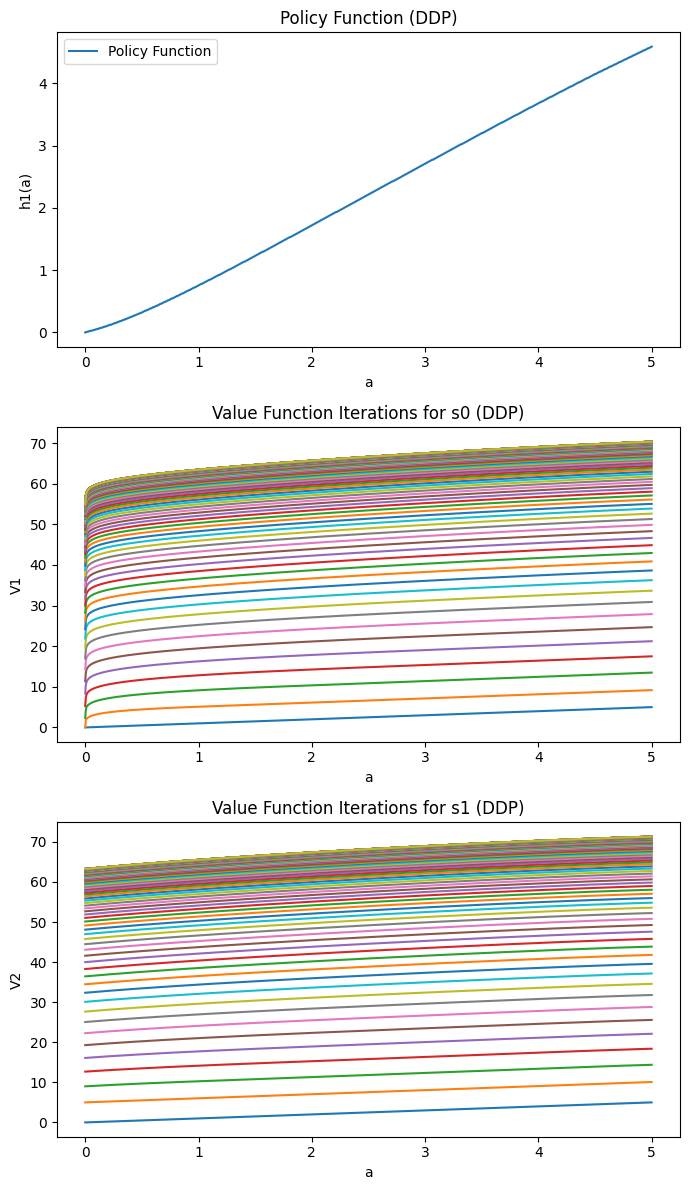

In [ ]:
# Set parameters
r = 0.1
sigma = 0.8
omega = 1
beta = 0.93
s0 = 0
s1 = 1
N = 1000
epsilon = 1e-3

start_time = time.time()
V1_ddp, h1_ddp, V2_ddp, h2_ddp, a_grid_ddp = Discrete_DP(r, sigma, omega, beta, s0, s1, N, epsilon)
end_time = time.time()
running_time = end_time - start_time
print(f"Elapsed time for Discrete: {running_time:.6f} seconds")

start_time = time.time()
V1_cmm, h1_cmm, V2_cmm, h2_cmm, a_grid_cmm = Continuous(r, sigma, omega, beta, s0, s1, N, epsilon)
end_time = time.time()
running_time = end_time - start_time
print(f"Elapsed time for Contionous: {running_time:.6f} seconds")


fig, axs = plt.subplots(3, 1, figsize=(7, 12))


axs[0].plot(a_grid_ddp, [h1_ddp(x) for x in a_grid_ddp])
axs[0].set_title('Policy Function (DDP)')
axs[0].legend(['Policy Function'], loc='upper left')
axs[0].set_xlabel('a')
axs[0].set_ylabel('h1(a)')

for i in range(len(V1_ddp)):
    axs[1].plot(a_grid_ddp, V1_ddp[i])
axs[1].set_title('Value Function Iterations for s0 (DDP)')
axs[1].set_xlabel('a')
axs[1].set_ylabel('V1')


for i in range(len(V2_ddp)):
    axs[2].plot(a_grid_ddp, V2_ddp[i])
axs[2].set_title('Value Function Iterations for s1 (DDP)')
axs[2].set_xlabel('a')
axs[2].set_ylabel('V2')


plt.tight_layout()
plt.show()


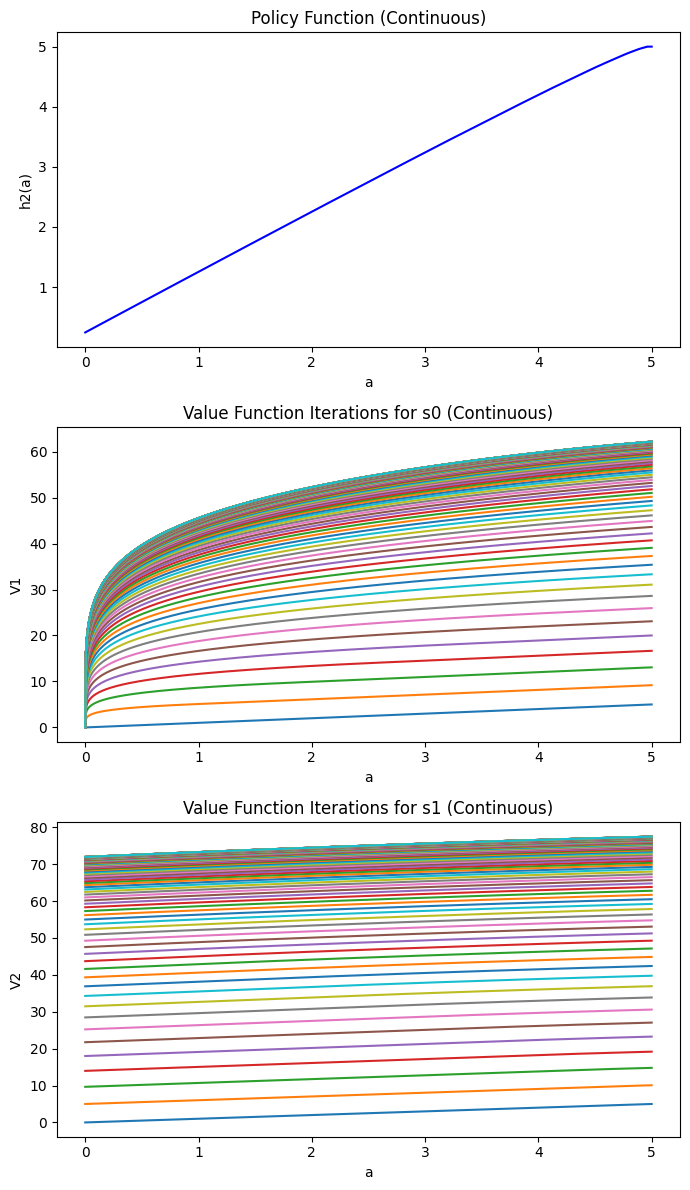

In [ ]:

def pf_c(x):
    return h2_cmm(x)


fig, axs = plt.subplots(3, 1, figsize=(7, 12))


axs[0].plot(a_grid_cmm, [pf_c(x) for x in a_grid_cmm], color='blue')
axs[0].set_title('Policy Function (Continuous)')
axs[0].set_xlabel('a')
axs[0].set_ylabel('h2(a)')


for i in range(len(V1_cmm)):
    axs[1].plot(a_grid_cmm, V1_cmm[i])
axs[1].set_title('Value Function Iterations for s0 (Continuous)')
axs[1].set_xlabel('a')
axs[1].set_ylabel('V1')


for i in range(len(V2_cmm)):
    axs[2].plot(a_grid_cmm, V2_cmm[i])
axs[2].set_title('Value Function Iterations for s1 (Continuous)')
axs[2].set_xlabel('a')
axs[2].set_ylabel('V2')

# Show plots
plt.tight_layout()
plt.show()


4.3 Using the Discrete version for the initial guess of the Continuous version

In [ ]:
def Bellman_Solver_mixed(r, sigma, omega, beta, s0, s1, N_new, epsilon):
    # Run DDP
    V1_ddp, h1_ddp, V2_ddp, h2_ddp, a_grid_ddp = Discrete_DP(r, sigma, omega, beta, s0, s1, N_new, epsilon)

    # Use results from DDP as initial guesses for CMM
    V1_cmm, h1_cmm, V2_cmm, h2_cmm, a_grid_cmm = Continuous(r, sigma, omega, beta, s0, s1, N_new, epsilon, initial_guess_1=V1_ddp[-1], initial_guess_2=V2_ddp[-1])

    return V1_cmm, h1_cmm, V2_cmm, h2_cmm, a_grid_cmm


Elapsed time: 177.475232 seconds


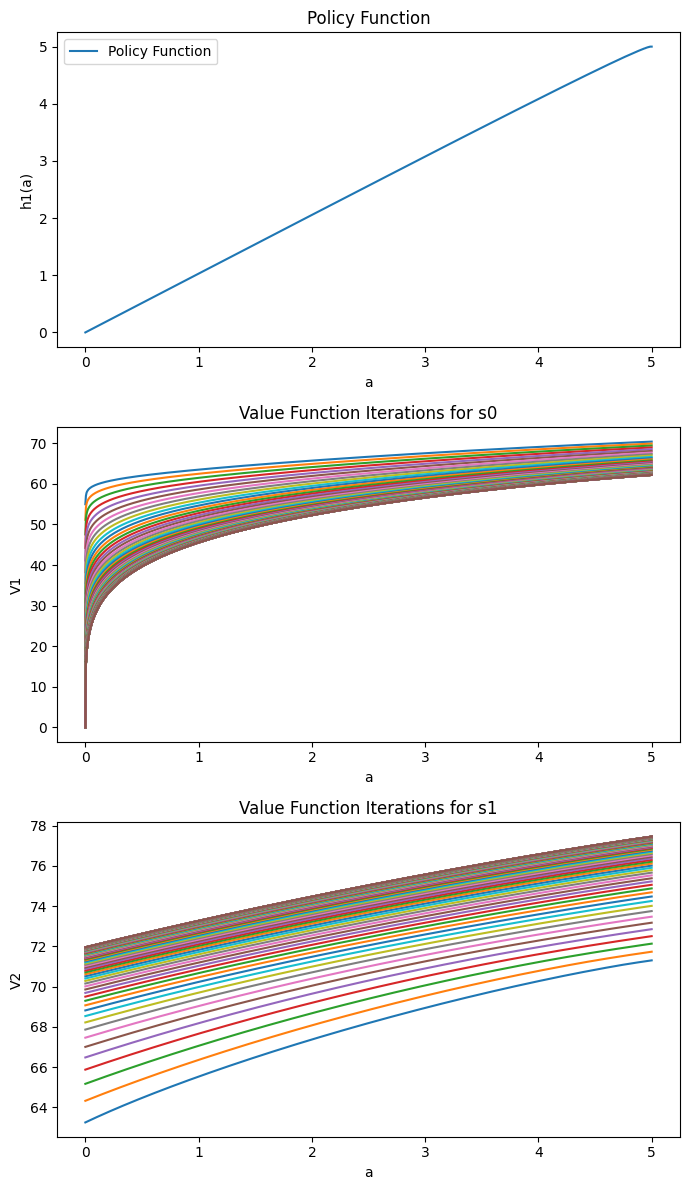

In [ ]:
import matplotlib.pyplot as plt
N_new = 1000

start_time = time.time()
V1, h1, V2, h2, a_grid = Bellman_Solver_mixed(r, sigma, omega, beta, s0, s1, N_new, epsilon)
end_time = time.time()
running_time = end_time - start_time
print(f"Elapsed time: {running_time:.6f} seconds")

def pf_m(x):
    return h1(x)


fig, axs = plt.subplots(3, 1, figsize=(7, 12))


axs[0].plot(a_grid, [pf_m(x) for x in a_grid])
axs[0].set_title('Policy Function')
axs[0].legend(['Policy Function'], loc='upper left')
axs[0].set_xlabel('a')
axs[0].set_ylabel('h1(a)')

for i in range(len(V1)):
    axs[1].plot(a_grid, V1[i])
axs[1].set_title('Value Function Iterations for s0')
axs[1].set_xlabel('a')
axs[1].set_ylabel('V1')


for i in range(len(V2)):
    axs[2].plot(a_grid, V2[i])
axs[2].set_title('Value Function Iterations for s1')
axs[2].set_xlabel('a')
axs[2].set_ylabel('V2')

plt.tight_layout()
plt.show()


the discrete version is much fatser, as the time elapsed can show that. using the mixed version should decrease the time needed for the calculations as well.